In [10]:
import torch
import torchvision
import pandas as pd
import os
from tqdm import tqdm
import pydicom
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload all
    
from utils import read_images
from datasets import SimpleFrameSelectionDataset
from models import resnet_binary

torch.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
images = read_images(ids="test")

Loaded test images from cache.


In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet_binary()
model.load_state_dict(torch.load('weights/frame_selection.pth'))
model.eval()
model = model.to(device)

transform = SimpleFrameSelectionDataset({}).transform

In [74]:
df = pd.read_csv("data/framerejectionfeedback.csv")
sel = df.groupby("IMAGE_ID")["SELECTEDFRAME"].apply(list)
rej = df.groupby("IMAGE_ID")["REJECTEDFRAME"].apply(list)

df = pd.DataFrame({"selected": sel, "rejected": rej})

images = {k:v for k, v in images.items() if k in df.index}
len(images)

105

In [75]:
def get_scores(img_id, smoothen=None):
    img = images[img_id] 
    img = transform(img.transpose(1,2,0)).to(device).unsqueeze(1)
    probs = torch.sigmoid(model(img))[:, 1]
    probs = probs.cpu().numpy()

    if smoothen is not None:
        kernel = np.hamming(smoothen)
        probs = np.convolve(probs, kernel/kernel.sum(), mode='same')

    return probs

In [116]:
def calculate_stats(get_scores_fun):
    stats = {}
    
    for img_id, row in df.iterrows():
        if img_id not in images:
            continue
        scores = get_scores_fun(img_id)
        top_n = np.argmax(scores)
        stats[img_id] = {
            "dist_from_selected": min(abs(top_n - n) for n in row["selected"]),
            "dist_from_rejected": min(abs(top_n - n) for n in row["rejected"]),
            "top_n_pos": min(list(np.argsort(-scores)).index(n) for n in row["selected"]),
            "seq_len": images[img_id].shape[0]
        }
    
    stats_df = pd.DataFrame(stats).T
    return stats_df

def calculate_metrics(stats_df):
    return dict(
        frame_distance = stats_df["dist_from_selected"].mean(),
        normalised_frame_distance = (stats_df["dist_from_selected"] / stats_df["seq_len"]).mean(),
        frame_rank = stats_df["top_n_pos"].mean(),
        normalised_frame_rank = (stats_df["top_n_pos"] / stats_df["seq_len"]).mean()
    )

{'frame_distance': 8.876190476190477,
 'normalised_frame_distance': 0.13677684943131502,
 'frame_rank': 17.476190476190474,
 'normalised_frame_rank': 0.2793414875026879}

In [158]:
stats = calculate_stats(get_scores)
ours_metrics = calculate_metrics(stats)
ours_metrics

{'frame_distance': 8.876190476190477,
 'normalised_frame_distance': 0.13677684943131502,
 'frame_rank': 17.476190476190474,
 'normalised_frame_rank': 0.2793414875026879}

In [159]:
def get_scores_random(img_id):
    img = images[img_id] 
    return np.random.random(img.shape[0])

stats = calculate_stats(get_scores_random)
random_metrics = calculate_metrics(stats)
random_metrics

{'frame_distance': 14.428571428571429,
 'normalised_frame_distance': 0.23216166529596147,
 'frame_rank': 24.714285714285715,
 'normalised_frame_rank': 0.4023217271058135}

In [160]:
def get_scores_middle(img_id):
    img = images[img_id] 
    scores = np.linspace(0, 1, 18)
    scores = np.hstack([scores[::2], scores[1::2][::-1]])
    return scores

stats = calculate_stats(get_scores_random)
middle_metrics = calculate_metrics(stats)
middle_metrics

{'frame_distance': 15.695238095238095,
 'normalised_frame_distance': 0.25993623706565416,
 'frame_rank': 21.285714285714285,
 'normalised_frame_rank': 0.35472842594792514}

In [112]:
def plot_frame_selection(img_id):
    probs = get_scores(img_id, smoothen=5)

    plt.figure(figsize=(12, 3)) 
    ax = sns.barplot(x=np.arange(len(probs)), y=probs, color="skyblue", width=0.8)
    ax.set_xticks(ax.get_xticks()[::2])

    max_prob_index = np.argmax(probs)
    ax.patches[max_prob_index].set_facecolor('blue')

    try:
        rejected = df.loc[img_id, "rejected"]
        selected = df.loc[img_id, "selected"]
        for r in rejected if type(rejected)!=np.int64 else [rejected]:
            plt.axvline(x=r, color='red', linestyle='--', label='Rejected')
        for s in selected if type(selected)!=np.int64 else [selected]:
            plt.axvline(x=s, color='green', linestyle='--', label='Selected')
    except KeyError as e:
        print(f"{e} not found in framerejectionfeedback")

    # Adding color legend
    handles = [
        plt.Line2D([0], [0], color='skyblue', lw=4, label='Frame Scores'),
        plt.Line2D([0], [0], color='blue', lw=4, label='Best Frame Prediction'),
        plt.Line2D([0], [0], color='red', linestyle='--', lw=2, label='Rejected ground truth'),
        plt.Line2D([0], [0], color='green', linestyle='--', lw=2, label='Accepted ground truth')
    ]
    plt.legend(handles=handles, loc='lower right')

    plt.title('Model Output Probabilities')
    plt.show()


'rejected' not found in framerejectionfeedback


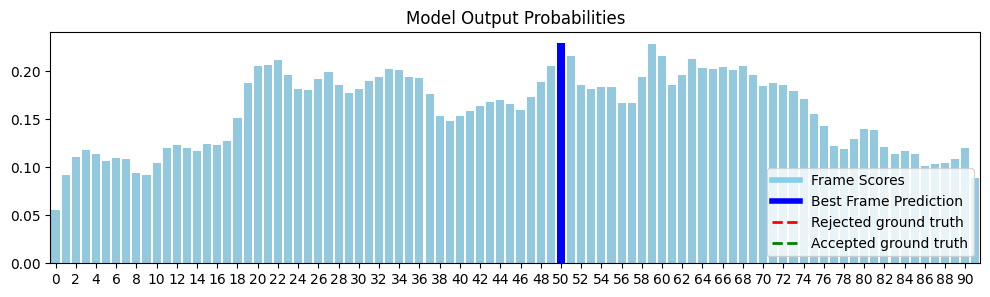

In [223]:
random_img_id = np.random.choice(list(images.keys()))
plot_frame_selection(random_img_id)

In [178]:
def imshow_frames(img_id, frames):
    img = images[img_id] 
    
    fig, axes = plt.subplots(1, len(frames), figsize=(3 * len(frames),  3))
    axes = axes.flatten() if len(frames) > 1 else [axes]
    
    for ax, frame in zip(axes, frames):
        ax.imshow(img[frame])
        ax.axis('off')
        ax.text(0.1, 0.1, str(frame), fontsize=14, color='white', transform=ax.transAxes)

    plt.tight_layout()
    plt.show()

#random_img_id = np.random.choice(list(images.keys()))

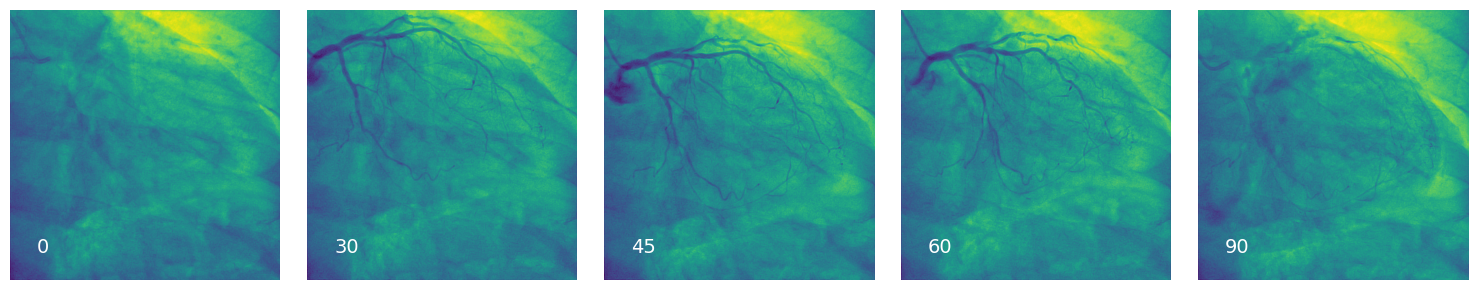

In [230]:
imshow_frames(random_img_id, [0, 30, 45, 60, 90])

In [148]:
example_img = images["131aedfhs6pnf1fvtvp49mj5g3q7xsrn22"]

In [161]:
import io
from PIL import Image
import numpy as np

def get_jpeg_size(img2d):
    pil_img = Image.fromarray(img2d)
    buffer = io.BytesIO()
    pil_img.save(buffer, format="JPEG", quality=10)
    return buffer.tell()
    
def get_entropy_baseline_scores(img_id):
    img = images[img_id] 
    sizes = np.array([get_jpeg_size(im) for im in img])
    return sizes / sizes.max()

stats = calculate_stats(get_entropy_baseline_scores)
entropy_metrics = calculate_metrics(stats)
entropy_metrics

{'frame_distance': 6.495238095238095,
 'normalised_frame_distance': 0.10947249243283043,
 'frame_rank': 11.4,
 'normalised_frame_rank': 0.17854239342990727}

In [165]:
a = pd.DataFrame(
    index=["Entropy", "Middle", "Random", "Ours"],
    data=[
        entropy_metrics,
        middle_metrics,
        random_metrics,
        ours_metrics
    ]).to_latex()

print(a)

\begin{tabular}{lrrrr}
\toprule
 & frame_distance & normalised_frame_distance & frame_rank & normalised_frame_rank \\
\midrule
Entropy & 6.495238 & 0.109472 & 11.400000 & 0.178542 \\
Middle & 15.695238 & 0.259936 & 21.285714 & 0.354728 \\
Random & 14.428571 & 0.232162 & 24.714286 & 0.402322 \\
Ours & 8.876190 & 0.136777 & 17.476190 & 0.279341 \\
\bottomrule
\end{tabular}

